# Importálások

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft
from scipy.signal import get_window
from scipy.signal import chirp, windows
import librosa
import librosa.display
import seaborn as sns
sns.set_theme()

dic = {"xtick.labelsize" : 20, "ytick.labelsize" : 20, "axes.titlesize" : 27, "axes.labelsize" : 20}
#plt.style.reload_library()
plt.style.use(dic)

In [9]:
x = np.linspace(0,4*np.pi,10000,endpoint=False)

In [38]:
y1 = np.sin(x)+5
y2 = np.concatenate((np.sin(x[:5000]),0*np.ones(5000,dtype=np.float64)),axis=-1)

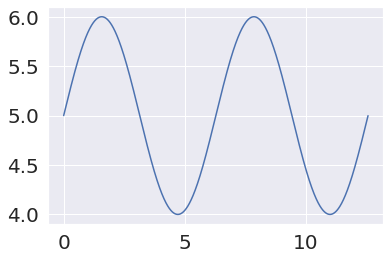

In [30]:
plt.plot(x,y1)

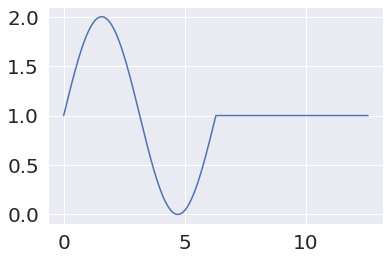

In [36]:
plt.plot(x,y2)


In [40]:
y1_ = rfft(y1)
y2_ = rfft(y2)

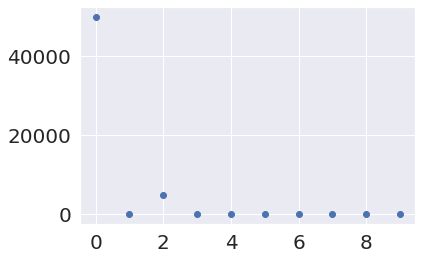

In [33]:
plt.plot(abs(y1_)[:10],'o')

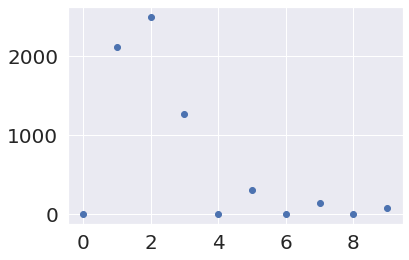

In [41]:
plt.plot(abs(y2_)[:10],'o')

In [42]:
from scipy.fft import irfft

In [43]:
y2__ = irfft(y2_)

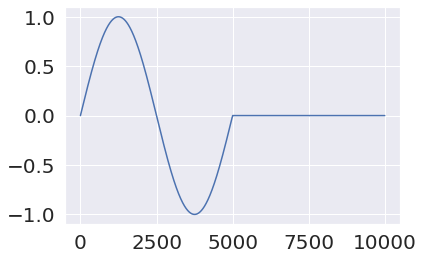

In [44]:
plt.plot(y2__)

In [45]:
y2__ == y2

array([False, False, False, ..., False,  True, False])

In [47]:
y2__

array([ 4.54747351e-17,  1.25663673e-03,  2.51327148e-03, ...,
       -3.63797881e-16,  0.00000000e+00,  1.81898940e-16])

In [49]:
from scipy.fft import fftfreq
fftfreq(8,1)

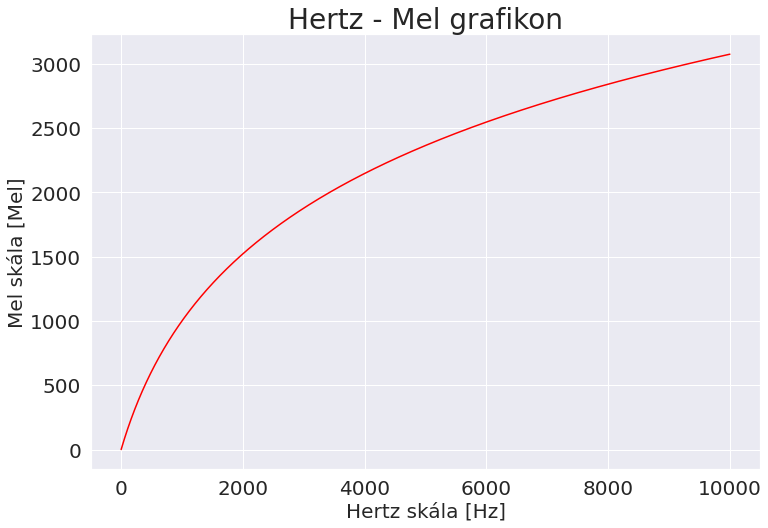

In [72]:
x = np.linspace(0,10000,10001,endpoint=True)
def fun(x):
    return 2595*np.log10(1+x/700)

plt.figure(figsize=(12,8))
plt.plot(x,fun(x),'',color='red')
plt.title("Hertz - Mel grafikon",fontsize=28)
plt.xlabel("Hertz skála [Hz]",fontsize=20)
plt.ylabel("Mel skála [Mel]",fontsize=20)
#plt.savefig("Mel.jpg")

# Azonos szintetikus teszt idősor

In [2]:
fs_s = 44100 #mintavételezési frekvencia
shft = 256 #későbbi hop_length

f1 = 100
f3 = 16000
t_jel = np.linspace(0, 5, 5 * fs_s)
f_jel = np.concatenate([f1 * np.ones(fs_s), f1 + (f3 - f1) * np.linspace(0, 1, 3 * fs_s), f3 * np.ones(fs_s)])
jel = np.concatenate([
    np.cos(2 * np.pi * f1 * t_jel[t_jel < 1]), 
    chirp(t_jel[t_jel < 3], f1, 3, f3), 
    np.cos(2 * np.pi * f3 * t_jel[t_jel < 1]) 
])

Text(0.5, 1.0, 'Próbajel frekvencia grafikon')

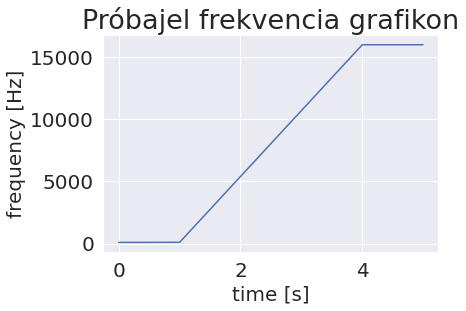

In [3]:
plt.plot(t_jel, f_jel)
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]');
plt.title("Próbajel frekvencia grafikon")

Text(0.5, 1.0, 'Próbajel kitérés-idő grafikon')

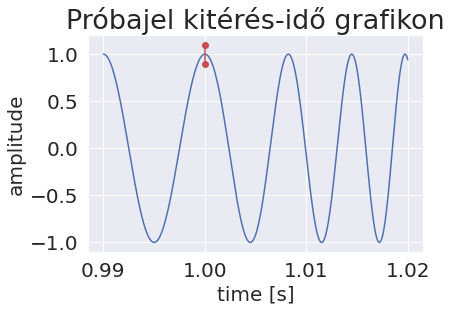

In [4]:
r = (t_jel > .99) & (t_jel < 1.02)
plt.plot(t_jel[r], jel[r])
plt.plot([1, 1], [.9, 1.1], 'ro-')
plt.xlabel('time [s]')
plt.ylabel('amplitude');
plt.title("Próbajel kitérés-idő grafikon")

# STFT

Paraméterek:
    
    -y vektor
    -sr (fizikai dimenziókhoz)
    -n_fft (ha n_fft != win_length -> keretenkénti zero padding)
    -win_length
    -hop_length
    -window (default: Hann)
    -center
    -pad_mode (reflect)

Padding eleje: pad_front = win_length // 2

Időkeretek száma: n_t = (len(y) - 1) // hop_length +1 (így az utolsó olyan centrumot is használjuk, ami még az eredeti hosszon belül van)

Padding vége: pad_end = n_t * win_length - (len(y) + win_length // 2)


A zero padding a Fourier transzformáció során látszatra javítja a spektrum felbontását, de a frekvenciacsúcsok is jobban elmosódnak és egymásba olvadnak, így két frekvencia nem lesz kevésbé megkülönböztethető egymástól, de ha csak egy frekvenciából áll a jel, akkor a zero paddinggel jobban be tudjuk határolni a frekvencia helyét.

## Saját STFT

In [5]:
def stft(y,sr,n_fft=2048,win_length=None,hop_length=None,window='hann',center=True,pad_mode='reflect'):
    '''Short Time Fourier Transzformáció (lineáris skálájú spectrogram).'''
    
    if win_length is None:
        win_length = n_fft
        
    if hop_length is None:
        hop_length = win_length // 4
        
    w = get_window(window, win_length, fftbins=False) #fftbins a librosa stft-ben True!!!!
    
    #teljes padding (a teljes jel elejére és végére hat)
    if center:
        n_t = (len(y) - 1) // hop_length + 1 #ennyi centrum fér bele a jelbe
        before = win_length // 2 #padding az elején
        after = n_t * win_length - (len(y) + win_length // 2) #padding a végén
        yp = np.pad(y,(before,after),mode = pad_mode) #y a padding után
        
        t_0 = 0 # a before padding eredményeként az első időpontunk az időskálánkon 0.
    else:
        n_t = len(y) // win_length #ennyiszer fér bele egészében az ablakméret (a jel végét levágjuk és nem használjuk)
        yp = y  #y a padding után (ebben az esetben nem változik)
        
        t_0 = (win_length // 2 +1) / sr #padding nélkül az első időszelet centruma ide esik
    
    t_n = t_0 + (n_t - 1) * hop_length / sr #az utolsó időpont közepe
    t_axis = np.linspace(t_0,t_n,n_t,endpoint=True)
    f_axis = np.linspace(0,sr/2,n_fft // 2 + 1, endpoint = True)
        
    specgram = np.empty((len(f_axis),n_t),dtype=complex) #komplex üres array a spektogram méretében
    if win_length == n_fft:
        for i in range(n_t):
            specgram[:,i] = rfft(w*yp[i*hop_length:i*hop_length+win_length])
    else:
        #ablakonkénti zero padding
        pad_sum = n_fft - win_length
        before = pad_sum // 2
        after = pad_sum // 2 + pad_sum % 2
        for i in range(n_t):
            specgram[:,i] = abs(rfft(np.pad(w*yp[i*hop_length:i*hop_length+win_length]),(before,after)))
        
    return (t_axis,f_axis,specgram)
    

In [6]:
#Librosa és saját spectrogram
spec_librosa = np.abs(librosa.stft(y=jel, hop_length=shft))
spec_own = np.abs(stft(jel,fs_s,hop_length=shft)[2])

Text(0.5, 1.0, 'Saját spectrogram \n matplotlib ábra')

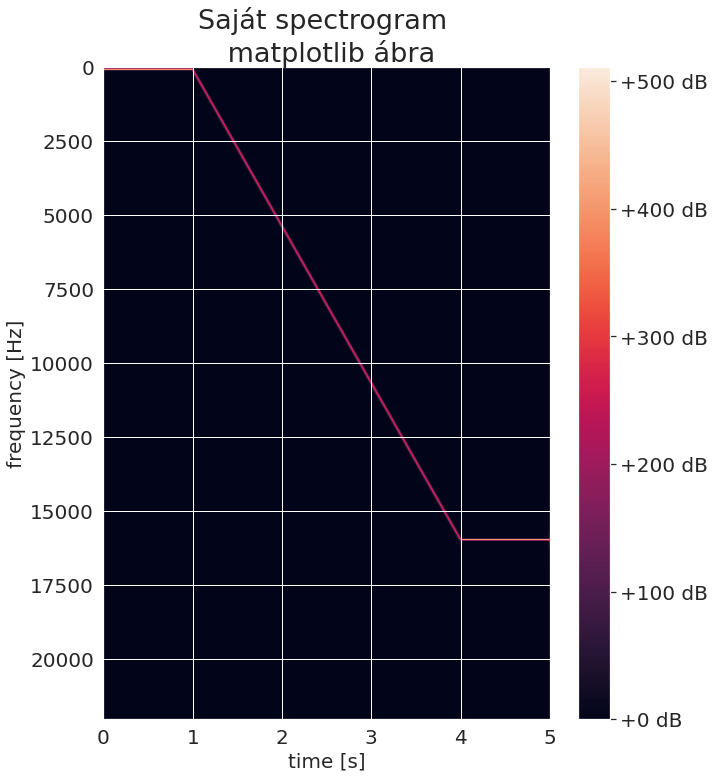

In [7]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 12))
cm = ax.imshow(spec_own, extent = [0, 5, fs_s / 2, 0], aspect = 'auto')
fig.colorbar(cm, ax = ax, format = '%+2.0f dB')
ax.set_xlabel('time [s]')
ax.set_ylabel('frequency [Hz]')
ax.set_title('Saját spectrogram \n matplotlib ábra')

## Innentől a librosa.display.specshow függvényt használom

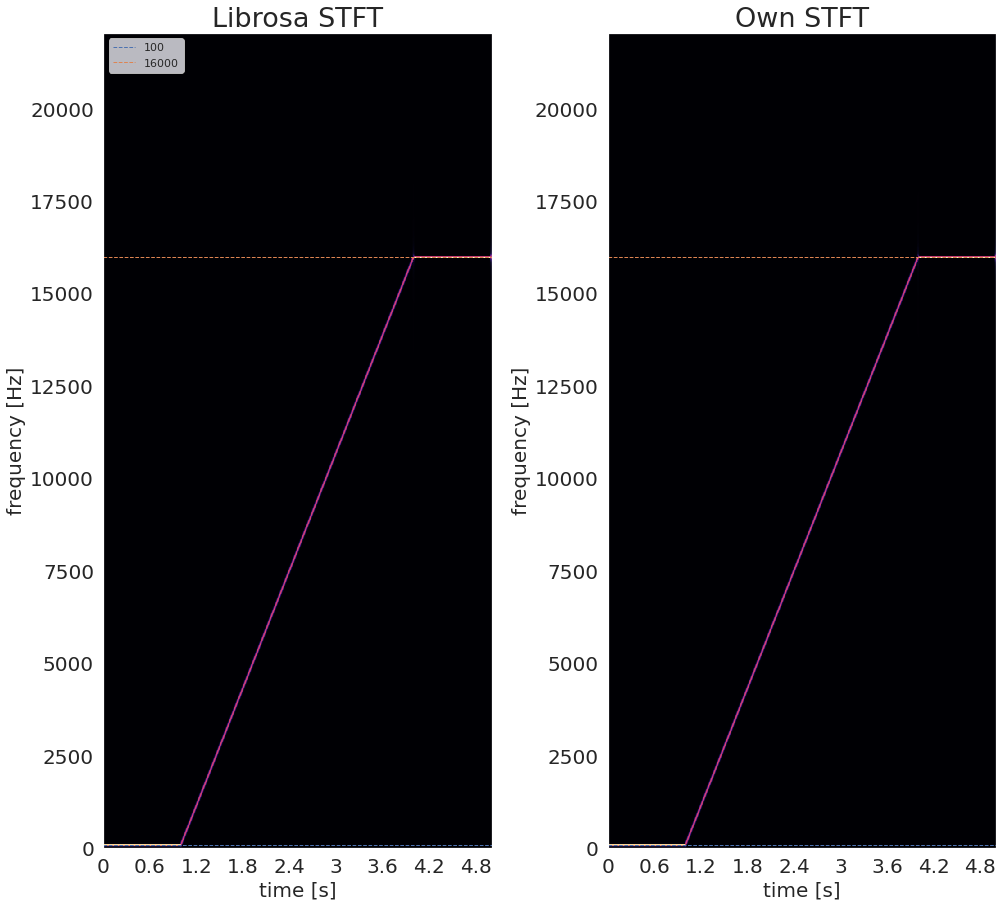

In [8]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (16, 15))

img = librosa.display.specshow(spec_librosa, x_axis='time',
                         y_axis='linear', sr=fs_s, hop_length=shft, fmin=0,
                         fmax=fs_s/2, ax=ax[0])
ax[0].plot(np.linspace(0,10,1001),100*np.ones(1001),'--',linewidth=1,label='100')
ax[0].plot(np.linspace(0,10,1001),16000*np.ones(1001),'--',linewidth=1,label='16000')
#fig.colorbar(img, ax = ax[0], format = '%+2.0f dB')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('frequency [Hz]')
ax[0].set_title('Librosa STFT')
ax[0].legend(loc='upper left')

img = librosa.display.specshow(spec_own, x_axis='time',
                         y_axis='linear', sr=fs_s, hop_length=shft, fmin=0,
                         fmax=fs_s/2, ax=ax[1])
#fig.colorbar(img, ax = ax[1], format = '%+2.0f dB')
ax[1].plot(np.linspace(0,10,1001),100*np.ones(1001),'--',linewidth=1,label='100')
ax[1].plot(np.linspace(0,10,1001),16000*np.ones(1001),'--',linewidth=1,label='16000')
ax[1].set_xlabel('time [s]',fontsize=20)
ax[1].set_ylabel('frequency [Hz]')
ax[1].set_title('Own STFT')

plt.subplots_adjust(wspace=0.3)

## Saját ábrázolóprogram lineáris spectrogramhoz

In [33]:
#még várat magára
def plot_linear_specgram(t,f,spec):
    specT = np.ones((spec.shape[0],spec.shape[1]))
    fT = np.ones(len(f))
    for i in range(spec.shape[0]):
        specT[i] = spec[spec.shape[0]-1-i]
        fT[i] = f[len(f)-1-i]
        
    print(fT)
        
    plt.figure(figsize=(12,8))
    plt.imshow(specT,aspect="auto")
    plt.xticks(np.linspace(0,len(t),10),[np.round(i,2) for i in np.linspace(t[0],t[-1],10)])
    plt.yticks(np.linspace(0,len(fT),10),[np.round(i,2) for i in np.linspace(fT[0],fT[-1],10)])

In [38]:
def plot_mel_specgram(t,f,spec):
    specT = np.ones((spec.shape[0],spec.shape[1]))
    fT = np.ones(len(f))
    for i in range(spec.shape[0]):
        specT[i] = spec[spec.shape[0]-1-i]
        fT[i] = f[len(f)-1-i]
        
    print(fT)
        
    plt.figure(figsize=(12,8))
    plt.imshow(specT,aspect="auto")
    plt.xticks(np.linspace(0,len(t),10),[np.round(i,2) for i in np.linspace(t[0],t[-1],10)])
    plt.yticks(np.linspace(0,len(fT),10),[np.round(i,2) for i in np.linspace(fT[0],fT[-1],10)])

[2.20500000e+04 2.20284668e+04 2.20069336e+04 ... 4.30664062e+01
 2.15332031e+01 0.00000000e+00]


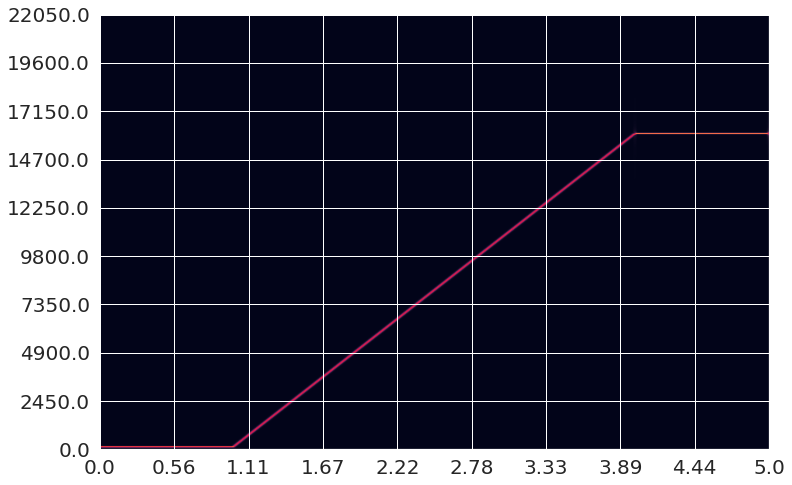

In [37]:
spec_own = stft(jel,fs_s,hop_length=shft)
plot_linear_specgram(spec_own[0],spec_own[1],np.abs(spec_own[2]))
#plt.plot(np.linspace(0,10,1000),np.ones(1000)*16000)

[2.20500000e+04 2.14442704e+04 2.08546685e+04 2.02807652e+04
 1.97221422e+04 1.91783929e+04 1.86491212e+04 1.81339416e+04
 1.76324788e+04 1.71443678e+04 1.66692530e+04 1.62067883e+04
 1.57566370e+04 1.53184711e+04 1.48919716e+04 1.44768279e+04
 1.40727376e+04 1.36794064e+04 1.32965478e+04 1.29238830e+04
 1.25611406e+04 1.22080564e+04 1.18643732e+04 1.15298407e+04
 1.12042154e+04 1.08872599e+04 1.05787436e+04 1.02784416e+04
 9.98613537e+03 9.70161190e+03 9.42466400e+03 9.15508997e+03
 8.89269348e+03 8.63728342e+03 8.38867377e+03 8.14668348e+03
 7.91113629e+03 7.68186066e+03 7.45868961e+03 7.24146059e+03
 7.03001539e+03 6.82420003e+03 6.62386460e+03 6.42886320e+03
 6.23905380e+03 6.05429817e+03 5.87446174e+03 5.69941355e+03
 5.52902610e+03 5.36317529e+03 5.20174035e+03 5.04460368e+03
 4.89165086e+03 4.74277047e+03 4.59785410e+03 4.45679620e+03
 4.31949403e+03 4.18584760e+03 4.05575956e+03 3.92913519e+03
 3.80588224e+03 3.68591097e+03 3.56913399e+03 3.45546625e+03
 3.34482497e+03 3.237129

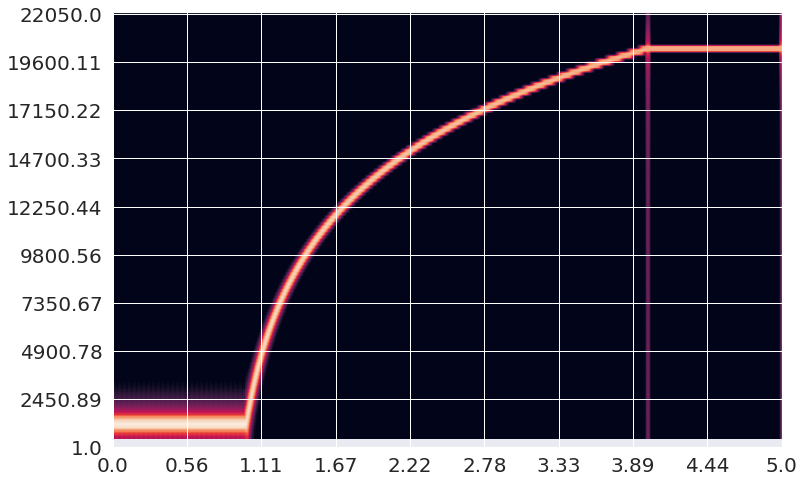

In [44]:
melspec = melspectrogram(y=jel,sr=fs_s,hop_length=shft)
#melspec[2] = librosa.power_to_db(melspectrogram(y=jel,sr=fs_s,hop_length=shft)[2], ref = np.max)
plot_mel_specgram(melspec[0],melspec[1],librosa.power_to_db(melspec[2],ref=np.max))

[2.20500000e+04 2.14442704e+04 2.08546685e+04 2.02807652e+04
 1.97221422e+04 1.91783929e+04 1.86491212e+04 1.81339416e+04
 1.76324788e+04 1.71443678e+04 1.66692530e+04 1.62067883e+04
 1.57566370e+04 1.53184711e+04 1.48919716e+04 1.44768279e+04
 1.40727376e+04 1.36794064e+04 1.32965478e+04 1.29238830e+04
 1.25611406e+04 1.22080564e+04 1.18643732e+04 1.15298407e+04
 1.12042154e+04 1.08872599e+04 1.05787436e+04 1.02784416e+04
 9.98613537e+03 9.70161190e+03 9.42466400e+03 9.15508997e+03
 8.89269348e+03 8.63728342e+03 8.38867377e+03 8.14668348e+03
 7.91113629e+03 7.68186066e+03 7.45868961e+03 7.24146059e+03
 7.03001539e+03 6.82420003e+03 6.62386460e+03 6.42886320e+03
 6.23905380e+03 6.05429817e+03 5.87446174e+03 5.69941355e+03
 5.52902610e+03 5.36317529e+03 5.20174035e+03 5.04460368e+03
 4.89165086e+03 4.74277047e+03 4.59785410e+03 4.45679620e+03
 4.31949403e+03 4.18584760e+03 4.05575956e+03 3.92913519e+03
 3.80588224e+03 3.68591097e+03 3.56913399e+03 3.45546625e+03
 3.34482497e+03 3.237129

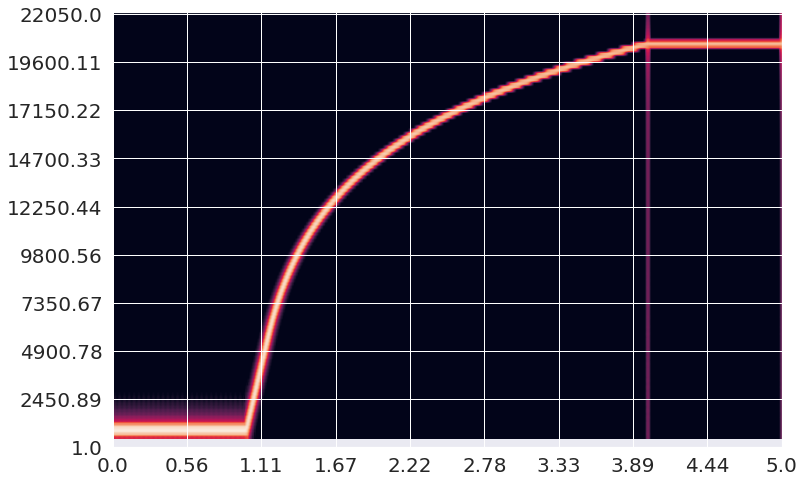

In [45]:
melspec_l = librosa.power_to_db(librosa.feature.melspectrogram(y=jel,sr=fs_s,hop_length=shft), ref = np.max)
plot_mel_specgram(melspec[0],melspec[1],melspec_l)

In [20]:
spec_own[0]

array([0.        , 0.00580499, 0.01160998, 0.01741497, 0.02321995,
       0.02902494, 0.03482993, 0.04063492, 0.04643991, 0.0522449 ,
       0.05804989, 0.06385488, 0.06965986, 0.07546485, 0.08126984,
       0.08707483, 0.09287982, 0.09868481, 0.1044898 , 0.11029478,
       0.11609977, 0.12190476, 0.12770975, 0.13351474, 0.13931973,
       0.14512472, 0.15092971, 0.15673469, 0.16253968, 0.16834467,
       0.17414966, 0.17995465, 0.18575964, 0.19156463, 0.19736961,
       0.2031746 , 0.20897959, 0.21478458, 0.22058957, 0.22639456,
       0.23219955, 0.23800454, 0.24380952, 0.24961451, 0.2554195 ,
       0.26122449, 0.26702948, 0.27283447, 0.27863946, 0.28444444,
       0.29024943, 0.29605442, 0.30185941, 0.3076644 , 0.31346939,
       0.31927438, 0.32507937, 0.33088435, 0.33668934, 0.34249433,
       0.34829932, 0.35410431, 0.3599093 , 0.36571429, 0.37151927,
       0.37732426, 0.38312925, 0.38893424, 0.39473923, 0.40054422,
       0.40634921, 0.4121542 , 0.41795918, 0.42376417, 0.42956

In [12]:
spec_own_transform = np.ones(spec_own[0],spec_own[1],np.abs(spec_own[2])
plt.imshow(spec_own)

SyntaxError: invalid syntax (<ipython-input-12-29fe26574bdf>, line 2)

# Saját mel filterbank

A mel filter-bank a szükséges trianguláris ablakokat tartalmazza mátrix formában, a teljes frekvenciatartományon az ablakon kívüli részeket kinullázva

In [40]:
def mel_convert(f):
    """Hz-ről mel-re konvertál."""
    return 2595 * np.log10(1 + f/700)

def mel_invert(m):
    """Mel-ről Hz-re konvertál"""
    return 700 * (10**(m/2595) - 1)

def create_freqs(sr,n_fft,n_mels):
    """Elkészíti a sampling rate (sr) és az ablakméret (n_fft) alapján a Fourier transzformáció
       frekvencia tengelyének pontjait, majd pedig a mel skálán elhelyezkedő frekvencia pontokat,
       melyekből összesen a megadott n_mels számú van."""
    f0_fix = 0
    f1_fix = sr / 2
    lin_freqs = np.linspace(f0_fix,f1_fix,n_fft//2+1,endpoint=True)
    m0_fix = mel_convert(f0_fix)
    m1_fix = mel_convert(f1_fix)
    mels = np.linspace(m0_fix,m1_fix,n_mels+2,endpoint=True)
    log_freqs = mel_invert(mels)
    return (lin_freqs,log_freqs)

def mel_triang(f,f_left,f_center,f_right):
    """A beadott f frekvenciához, mint független változóhoz hozzárendel egy függvény
       értéket, mint a háromszög ablakfüggvény egy súlyértékét (a háromszögön kívül 0).
       A háromszög határai az f_left és az f_right, csúcshelye pedig f_center."""
    if (f_left < f and f <= f_center):
        return ((f - f_left) / (f_center - f_left)) * 2 / (f_right - f_left)
                #normalizálás a háromszög alapjának területével (slaney normalization).
                #a dokumentációban azt írják, hogy a háromszög hosszával normalizálnak, de a forráskódban
                #végül mégis a háromszög területét használják (* 2 / alap (mivel az alaphoz tartozó
                #magasság 1))
    elif (f_center < f and f < f_right):
        return ((f - f_right) / (f_center - f_right)) * 2 / (f_right - f_left)
    else:
        return 0
    
def generate_mel_filterbank(sr,n_fft,n_mels=128):
    """Minden időkerethez tartozik egy súlyvektor, mellyel összeszorozva át tudunk mappalni egy
       időkerethez tartozó frekvencia értékeket a melfrekvencia tengelyünkre. Ha ezeket a vektorokat
       egymásra rakjuk, megkapjuk a mel filterbankot, amit ez a függvény kiszámol és visszaad.
       A mel filterbank egy (n_mels,n_fft // 2 + 1) alakú mátrix."""
    lin_freqs, log_freqs = create_freqs(sr,n_fft,n_mels) #a lineáris f skála és a mel skála pontjai
    melfb = np.empty((n_mels,len(lin_freqs)))
    for i in range(1,len(log_freqs)-1):
        mfbi = []
        for j in range(len(lin_freqs)):
            mfbi.append(mel_triang(lin_freqs[j],log_freqs[i-1],log_freqs[i],log_freqs[i+1])) #háromszögsúlyok
        melfb[i-1,:] = mfbi
    return (log_freqs, melfb)

## create_freqs teszt

In [11]:
linf,logf = create_freqs(44100,2048,128)

In [12]:
linf

array([0.00000000e+00, 2.15332031e+01, 4.30664062e+01, ...,
       2.20069336e+04, 2.20284668e+04, 2.20500000e+04])

In [13]:
logf.shape

(130,)

In [14]:
logf

array([0.00000000e+00, 1.91476507e+01, 3.88190622e+01, 5.90285613e+01,
       7.97908667e+01, 1.01121100e+02, 1.23034796e+02, 1.45547914e+02,
       1.68676851e+02, 1.92438453e+02, 2.16850024e+02, 2.41929344e+02,
       2.67694678e+02, 2.94164792e+02, 3.21358964e+02, 3.49296999e+02,
       3.77999245e+02, 4.07486607e+02, 4.37780559e+02, 4.68903166e+02,
       5.00877094e+02, 5.33725630e+02, 5.67472698e+02, 6.02142876e+02,
       6.37761415e+02, 6.74354255e+02, 7.11948048e+02, 7.50570174e+02,
       7.90248761e+02, 8.31012708e+02, 8.72891703e+02, 9.15916248e+02,
       9.60117676e+02, 1.00552818e+03, 1.05218084e+03, 1.10010962e+03,
       1.14934943e+03, 1.19993614e+03, 1.25190659e+03, 1.30529863e+03,
       1.36015114e+03, 1.41650407e+03, 1.47439847e+03, 1.53387650e+03,
       1.59498149e+03, 1.65775792e+03, 1.72225153e+03, 1.78850928e+03,
       1.85657943e+03, 1.92651156e+03, 1.99835660e+03, 2.07216687e+03,
       2.14799613e+03, 2.22589961e+03, 2.30593404e+03, 2.38815772e+03,
      

## A trianguláris szűrő függvényének tesztelése

A háromszög területe = 1.0


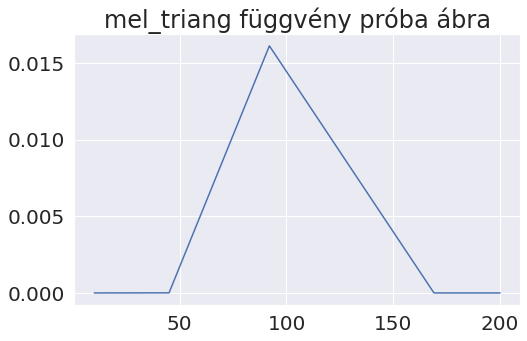

In [41]:
import scipy.integrate as integrate

f_min = 10
f_max = 200
db = 19001
f_l = 45
f_c = 92
f_r = 169

def f_int1(f,f_l=f_l,f_c=f_c,f_r=f_r): #háromszög ablakfüggvénye f_left-től a centerig
    return ((f - f_l) / (f_c - f_l)) * 2 / (f_r - f_l)

def f_int2(f,f_l=f_l,f_c=f_c,f_r=f_r): #háromszög ablakfüggvénye a center után f_right-ig
    return ((f - f_r) / (f_c - f_r)) * 2 / (f_r - f_l)

x = np.linspace(f_min,f_max,db)
y = np.array([mel_triang(f,f_l,f_c,f_r) for f in x])
I = integrate.quad(f_int1,f_l,f_c)[0] + integrate.quad(f_int2,f_c,f_r)[0]
print("A háromszög területe = {}".format(I)) #slaney normalizáció: a háromszög területének
                                           #kétszeresével osztjuk le a függvény értékeit -> T = 0.5
fig, ax = plt.subplots(ncols=1,nrows=1,figsize = (8,5))
ax.plot(x,y);
ax.set_title("mel_triang függvény próba ábra",fontsize=24);

## Játék a mel filterbankokkal

In [16]:
# Itt készítettem el a saját és beépített függvény segítségével a fenti jelhez tartozó mel filterbankokat
_,melfb_own = generate_mel_filterbank(44100,2048)
melfb_librosa = librosa.filters.mel(44100,2048)

In [17]:
for i in sum(melfb_librosa == 0):
    print(i)

128
127
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126


In [18]:
len(sum(melfb_own == 0))

1025

In [19]:
for i in sum(melfb_own == 0):
    print(i)

128
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126


In [20]:
sum(sum(abs(librosa.filters.mel(44100,2048) - generate_mel_filterbank(44100,2048)[1]) > 0.005))

535

In [21]:
melfb_own.shape

(128, 1025)

In [22]:
melfb_librosa.shape

(128, 1025)

A saját és a librosa általi melfb-k között az a legnagyobb különbség, hogy az én értékeim szisztematikusan nagyobbak valamiért (ezen kívül a beépített filterbank magasabban megy).

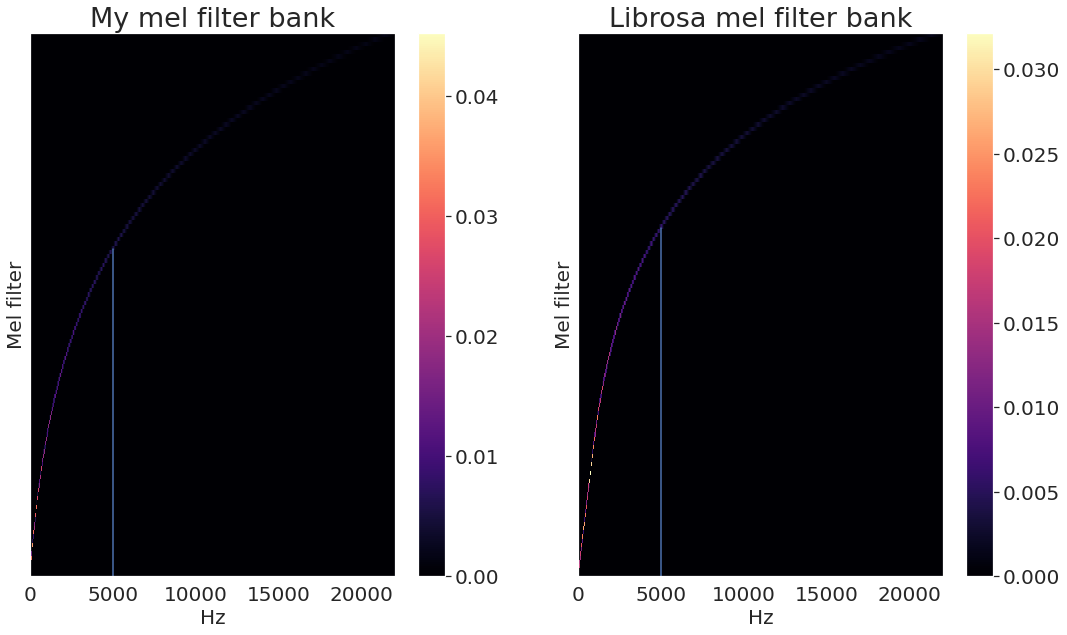

In [23]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize = (18,10))
img = librosa.display.specshow(melfb_own, sr=fs_s, x_axis='linear', ax=ax[0])
ax[0].set(ylabel='Mel filter', title='My mel filter bank')
ax[0].plot((5000,5000),(0,77)) #itt 5000 Hz-nél alacsonyabb a vonalam
fig.colorbar(img, ax=ax[0]);

img = librosa.display.specshow(melfb_librosa,sr=fs_s, x_axis='linear', ax=ax[1])
ax[1].set(ylabel='Mel filter', title='Librosa mel filter bank')
ax[1].plot((5000,5000),(0,82))
fig.colorbar(img, ax=ax[1]);

# Saját melspectrogram

In [42]:
def melspectrogram(y=None,sr=22050,S=None,n_fft=2048,win_length=None,hop_length=None,window='hann',center=True,pad_mode='reflect',
                  power=2,n_mels=128):
    """Ha y nem None, akkor először az y és a többi paraméter alapján készít egy magnitude spektrumot
       (ha nincs y és van S, akkor S-t használja fel), kiszámolja a mel filterbankot, majd a kettő szorzatából
       visszaadja a melspectrogramot (y paraméter esetén az idő és melfrekvencia tengelyeket is visszaadja)."""
    if (y is not None):
        t_axis, _, specgram = stft(y,sr,n_fft,win_length,hop_length,window,center,pad_mode)
        f_axis_log, melfb = generate_mel_filterbank(sr,n_fft,n_mels)
        specgram = np.abs(specgram) ** power #fázis elveszik
        melspecgram = melfb @ specgram
        return t_axis, f_axis_log, melspecgram
    elif (S is not None):
        melfb = librosa.filters.mel(sr,n_fft,n_mels)
        S = np.abs(S) ** power
        melspecgram = melfb @ S
        return (None, None, melspecgram)
    else:
        raise ValueError("y és S nem lehet egyszerre None!")


# Saját és librosa stft és melspectrogram összehasonlítása

In [25]:
#{o : own, l : librosa, s: stft, m : melspectrogram}
#itt elhittem, hogy a librosa.power_to_db függvény egységesen és jól működik

melspec_l_s_l_m_DB = librosa.power_to_db(librosa.feature.melspectrogram(y=jel,sr=fs_s,hop_length=shft), ref = np.max)
melspec_l_s_o_m_DB = librosa.power_to_db(melspectrogram(S=spec_librosa,sr=fs_s,hop_length=shft)[2], ref = np.max)
melspec_o_s_o_m_DB = librosa.power_to_db(melspectrogram(y=jel,sr=fs_s,hop_length=shft)[2], ref = np.max)
melspec_o_s_l_m_DB = librosa.power_to_db(librosa.feature.melspectrogram(S=spec_own,sr=fs_s,hop_length=shft), ref = np.max)

Valamiért a teljes mértékben saját kód által készített ábra lejjebb helyezkedik el, mint a többinél.

/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has bee

[Text(0.5, 1.0, 'own stft librosa melspec')]

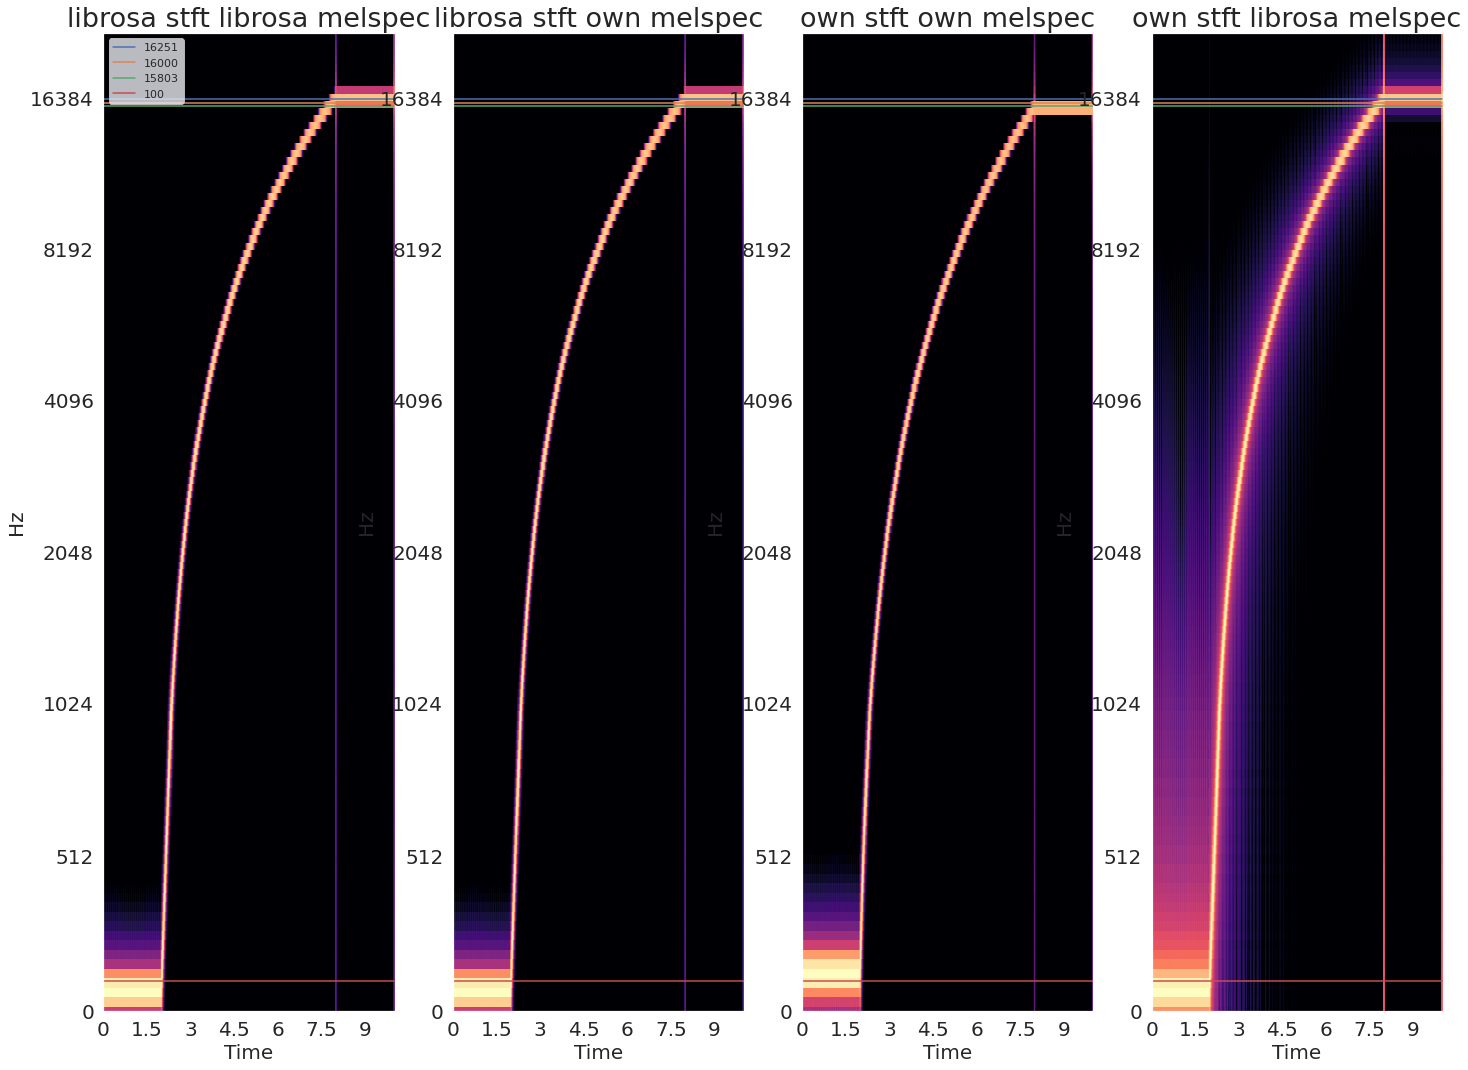

In [26]:
fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (24,18))
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(melspec_l_s_l_m_DB, x_axis='time',
                         y_axis='mel', sr=fs_s,
                         fmax=fs_s/2, ax=ax[0])
ax[0].plot(np.linspace(0,10,1001),16251*np.ones(1001),label='16251')
ax[0].plot(np.linspace(0,10,1001),16000*np.ones(1001),label='16000')
ax[0].plot(np.linspace(0,10,1001),15803*np.ones(1001),label='15803')
ax[0].plot(np.linspace(0,10,1001),100*np.ones(1001),label='100')
#fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='librosa stft librosa melspec')
ax[0].legend(loc='upper left')

img = librosa.display.specshow(melspec_l_s_o_m_DB, x_axis='time',
                         y_axis='mel', sr=fs_s,
                         fmax=fs_s/2, ax=ax[1])
ax[1].plot(np.linspace(0,10,1001),16251*np.ones(1001))
ax[1].plot(np.linspace(0,10,1001),16000*np.ones(1001))
ax[1].plot(np.linspace(0,10,1001),15803*np.ones(1001))
ax[1].plot(np.linspace(0,10,1001),100*np.ones(1001))
ax[1].set(title='librosa stft own melspec')

img = librosa.display.specshow(melspec_o_s_o_m_DB, x_axis='time',
                         y_axis='mel', sr=fs_s,
                         fmax=fs_s/2, ax=ax[2])
ax[2].plot(np.linspace(0,10,1001),16251*np.ones(1001))
ax[2].plot(np.linspace(0,10,1001),16000*np.ones(1001))
ax[2].plot(np.linspace(0,10,1001),15803*np.ones(1001))
ax[2].plot(np.linspace(0,10,1001),100*np.ones(1001))
ax[2].set(title='own stft own melspec')


img = librosa.display.specshow(melspec_o_s_l_m_DB, x_axis='time',
                         y_axis='mel', sr=fs_s,
                         fmax=fs_s/2, ax=ax[3])
ax[3].plot(np.linspace(0,10,1001),16251*np.ones(1001))
ax[3].plot(np.linspace(0,10,1001),16000*np.ones(1001))
ax[3].plot(np.linspace(0,10,1001),15803*np.ones(1001))
ax[3].plot(np.linspace(0,10,1001),100*np.ones(1001))
ax[3].set(title='own stft librosa melspec')

# A beépített melspectogram és ábrázolásának tesztelése

Az egyik eddigi hiba, hogy az y_axis-ra 'log' volt beállítva 'mel' helyett (a log skála máshol megy, ez okozhatja az elcsúszást). Kérdés még, hogy az fmax alapértelmezetten (még a forráskód szerint is) az sr-t állítja be, de valamiért nekem mégis csak akkor működik jól, ha explicit beállítom.

/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jakobi/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has bee

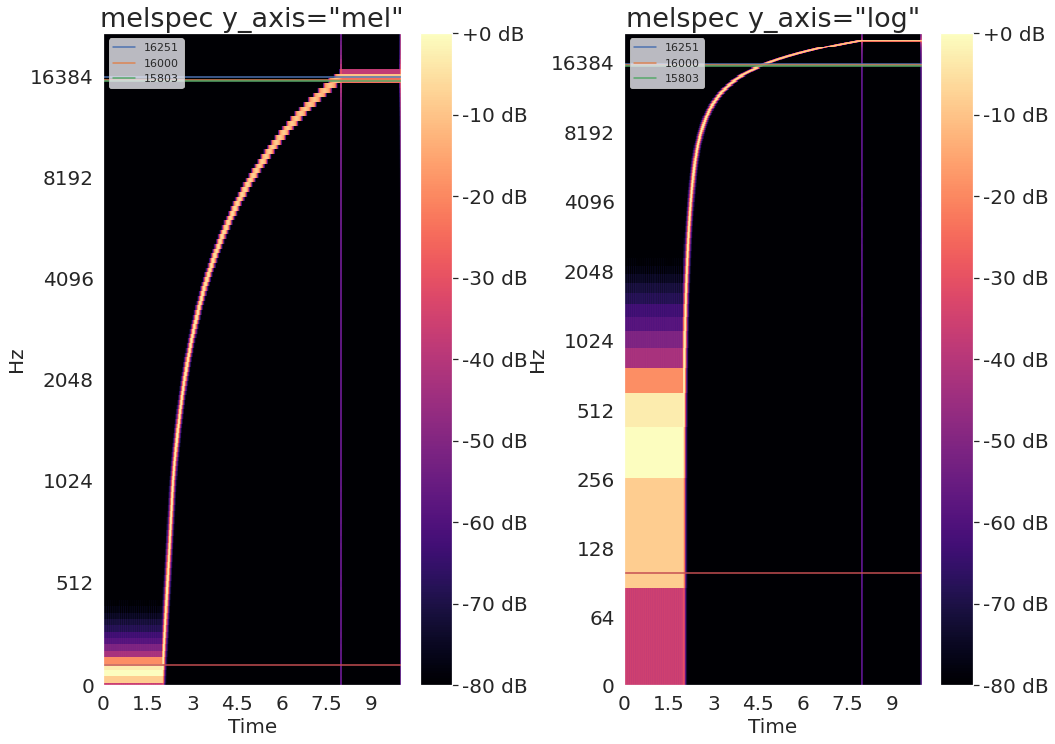

In [27]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize = (16,12))
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(melspec_l_s_l_m_DB, x_axis='time',
                         y_axis='mel', sr=fs_s,
                         fmax=fs_s/2, ax=ax[0])
ax[0].plot(np.linspace(0,10,1001),16251*np.ones(1001),label='16251')
ax[0].plot(np.linspace(0,10,1001),16000*np.ones(1001),label='16000')
ax[0].plot(np.linspace(0,10,1001),15803*np.ones(1001),label='15803')
ax[0].plot(np.linspace(0,10,1001),100*np.ones(1001))
ax[0].legend(loc='upper left')
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='melspec y_axis="mel"')

img = librosa.display.specshow(melspec_l_s_l_m_DB, x_axis='time',
                         y_axis='log', sr=fs_s,
                         fmax=fs_s/2, ax=ax[1])
ax[1].plot(np.linspace(0,10,1001),16251*np.ones(1001),label='16251')
ax[1].plot(np.linspace(0,10,1001),16000*np.ones(1001),label='16000')
ax[1].plot(np.linspace(0,10,1001),15803*np.ones(1001),label='15803')
ax[1].plot(np.linspace(0,10,1001),100*np.ones(1001))
ax[1].legend(loc='upper left')
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
ax[1].set(title='melspec y_axis="log"')

plt.subplots_adjust(wspace=0.4)